Basic script to visualize the shedding curve utilized in the INSIDe demonstrator

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from matplotlib import rc

In [2]:
# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [3]:
plot_path = f"../plots/shedding_model/"
os.makedirs(plot_path, exist_ok=True)

/tmp/ipykernel_358321/2675628791.py:205: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([a1, a2, a4, a5, a7, a8], labels=labels,


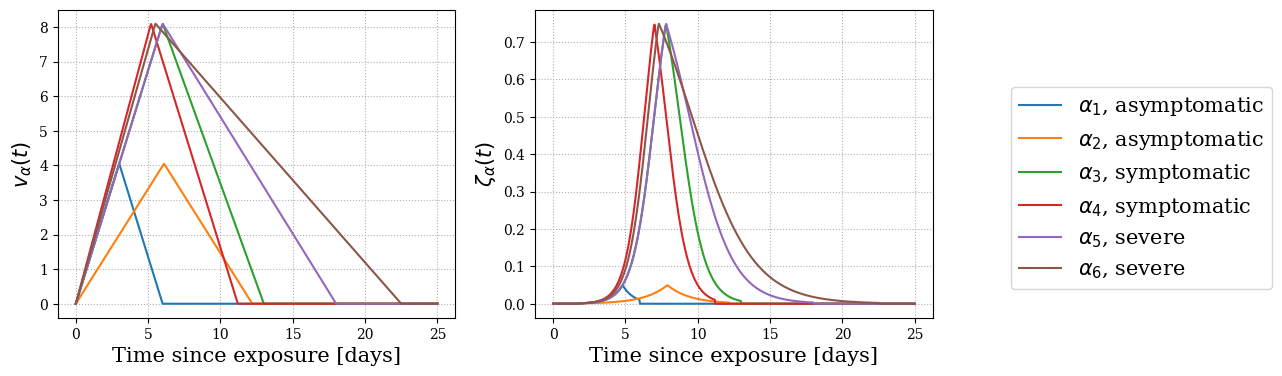

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt


class Infection:
    '''
    T_E: time the agent is exposed
    T_INS: time the agent is non-symptomatic
    T_ISy: time the agent is symptomatic
    T_ISev: time the agent is severely infected
    T_ICri: time the agent is critically infected
    '''

    def __init__(self, T_E, T_INS, T_ISy, T_ISev, T_ICri):
        self.T_infected = T_E + T_INS + T_ISy + T_ISev + T_ICri
        self.t_limit = 1.3
        self.peak = 8.1
        self.t_E = 0
        # self.t_shift = T_E - self.t_limit
        self.t_shift = 0.6 * T_E
        self.t_end = self.t_E + self.T_infected
        self.t_peak = self.t_E + T_E + T_INS
        self.incline = self.peak / (self.t_peak - self.t_E)
        self.kappa = 0.075
        # adapt peak and decline for asymptomatic course
        if (T_ISy == 0):
            self.t_peak = self.t_E + 0.5 * self.T_infected
            self.peak = self.incline * (self.t_peak - self.t_E)
        self.decline = -self.peak / (self.t_end - self.t_peak)
        self.alpha = -7.0
        self.beta = 1.0

    def get_viral_load(self, t):
        if (t >= self.t_E and t <= self.t_peak):
            return self.incline * (t-self.t_E)
        elif (t > self.t_peak and t <= self.t_end):
            return self.peak + self.decline * (t-self.t_peak)
        else:
            return 0

    def get_infectivity(self, t):
        if (t <= self.t_shift or t > self.t_end):
            return 0
        return self.kappa * 1 / (1 + math.exp(-(self.alpha + self.beta * self.get_viral_load(t-self.t_shift))))


# infection = Infection(2.4672, 3.46936, 9.21504, 0, 0)

time = np.linspace(0, 25, 500)
infection1 = Infection(3.0, 3.0, 0, 0, 0)
y1 = [infection1.get_infectivity(t) for t in time]
v1 = [infection1.get_viral_load(t) for t in time]
infection2 = Infection(3.0, 3.0, 7.0, 0, 0)
y2 = [infection2.get_infectivity(t) for t in time]
v2 = [infection2.get_viral_load(t) for t in time]
infection3 = Infection(3.0, 3.0, 7.0, 5.0, 0)
y3 = [infection3.get_infectivity(t) for t in time]
v3 = [infection3.get_viral_load(t) for t in time]

# fig, ax = plt.subplots()
# ax.plot(time, y1, label="Asymptomatic")
# ax.plot(time, y2, label="Symptomatic")
# ax.plot(time, y3, label="Severe")
# ax.set_xlabel("Time[days] since transmission")
# ax.set_ylabel("Infectiousness")
# ax.legend()
# ax.set_title("Different severities, same times")
# fig.savefig("infectiouseness1_new.png")

# fig2, ax2 = plt.subplots()
# ax2.plot(time, v1, label="Asymptomatic")
# ax2.plot(time, v2, label="Symptomatic")
# ax2.plot(time, v3, label="Severe")
# ax2.set_xlabel("Time[days] since transmission")
# ax2.set_ylabel("Viral load[Log]")
# ax2.legend()
# ax2.set_title("Different severities, same times")
# fig2.savefig("viralload1_new.png")

#different asymptomatic courses
infection4 = Infection(3.0, 9.2, 0, 0, 0)
y4 = [infection4.get_infectivity(t) for t in time]
v4 = [infection4.get_viral_load(t) for t in time]
infection5 = Infection(3.0, 7.0, 0, 0, 0)
y5 = [infection5.get_infectivity(t) for t in time]
v5 = [infection5.get_viral_load(t) for t in time]
infection6 = Infection(3.0, 10.0, 0, 0, 0)
y6 = [infection6.get_infectivity(t) for t in time]
v6 = [infection6.get_viral_load(t) for t in time]

# fig, ax = plt.subplots()
# ax.plot(time, y1, label="T_INS=3")
# ax.plot(time, y4, label="T_INS=9.2")
# ax.plot(time, y5, label="T_INS=7")
# ax.plot(time, y6, label="T_INS=10")
# ax.set_xlabel("Time[days] since transmission")
# ax.set_ylabel("Infectiousness")
# ax.legend()
# ax.set_title("Asymptomatic, different times")
# fig.savefig("infectiouseness2_new.png")

# fig2, ax2 = plt.subplots()
# ax2.plot(time, v1, label="T_INS=3")
# ax2.plot(time, v4, label="T_INS=9.2")
# ax2.plot(time, v5, label="T_INS=7")
# ax2.plot(time, v6, label="T_INS=10")
# ax2.set_xlabel("Time[days] since transmission")
# ax2.set_ylabel("Viral load[Log]")
# ax2.legend()
# ax.set_title("Asymptomatic, different times")
# fig2.savefig("viralload2_new.png")

#plot all
infection7 = Infection(3.0, 2.2, 6.0, 0, 0)
y7 = [infection7.get_infectivity(t) for t in time]
v7 = [infection7.get_viral_load(t) for t in time]
infection8 = Infection(3.0, 2.5, 7.0, 10., 0)
y8 = [infection8.get_infectivity(t) for t in time]
v8 = [infection8.get_viral_load(t) for t in time]
infection9 = Infection(3.0, 4, 4.0, 0, 0)
y9 = [infection9.get_infectivity(t) for t in time]
v9 = [infection9.get_viral_load(t) for t in time]
infection10 = Infection(3.0, 3.5, 5.0, 7., 0)
y10 = [infection10.get_infectivity(t) for t in time]
v10 = [infection10.get_viral_load(t) for t in time]

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

fig, ax = plt.subplots(1, 2, figsize=(14,4))
#ax.legend()
#ax.set_title("Different courses, different times")
#fig.savefig("infectiouseness3_new.png")

#fig, ax = plt.subplots()
#asymptomatic
ax[0].plot(time, v1, label=r'$\alpha_1$, asymptomatic')
ax[0].plot(time, v4, label=r'$\alpha_2$, asymptomatic')
#ax[0].plot(time, v5, label=r'$\alpha_3$, asymptomatic')
#symptomatic
ax[0].plot(time, v2, label=r'$\alpha_4$, symptomatic')
ax[0].plot(time, v7, label=r'$\alpha_5$, symptomatic')
#ax[0].plot(time, v9, label=r'$\alpha_6$, symptomatic')
#severe
ax[0].plot(time, v3, label=r'$\alpha_7$, severe')
ax[0].plot(time, v8, label=r'$\alpha_8$, severe')
ax[0].grid(linestyle='dotted')
#ax[0].plot(time, v10, label=r'$\alpha_9$, severe')
ax[0].set_xlabel("time since exposure [days]", fontsize=15)
#ax.set_ylabel("Viral load[Log]")
ax[0].set_ylabel(r'$v_\alpha(t)$', fontsize=15)

#asymptomatic
a1 = ax[1].plot(time, y1, label=r'$\alpha_1$, asymptomatic')
a2 = ax[1].plot(time, y4, label=r'$\alpha_2$, asymptomatic')
#a3 = ax[1].plot(time, y5, label=r'$\alpha_3$, asymptomatic')
#symptomatic
a4 = ax[1].plot(time, y2, label=r'$\alpha_4$, symptomatic')
a5 = ax[1].plot(time, y7, label=r'$\alpha_5$, symptomatic')
#a6 = ax[1].plot(time, y9, label=r'$\alpha_6$, symptomatic')
#severe
a7 = ax[1].plot(time, y3, label=r'$\alpha_7$, severe')
a8 = ax[1].plot(time, y8, label=r'$\alpha_8$, severe')
ax[1].grid(linestyle='dotted')
#a9 = ax[1].plot(time, y10, label=r'$\alpha_9$, severe')
ax[1].set_xlabel("time since exposure [days]", fontsize=15)
ax[1].set_ylabel(r'$\lambda_\alpha(t)$', fontsize=15)

#ax.legend(loc='center left', )
# labels = [r'$\alpha_1$, asymptomatic', r'$\alpha_2$, asymptomatic', r'$\alpha_3$, asymptomatic',
#           r'$\alpha_4$, symptomatic', r'$\alpha_5$, symptomatic', r'$\alpha_6$, symptomatic', 
#           r'$\alpha_7$, severe', r'$\alpha_8$, severe', r'$\alpha_9$, severe']
labels = [r'$\alpha_1$, asymptomatic', r'$\alpha_2$, asymptomatic', r'$\alpha_3$, symptomatic',
          r'$\alpha_4$, symptomatic', r'$\alpha_5$, severe', r'$\alpha_6$, severe']
fig.legend([a1, a2, a4, a5, a7, a8], labels=labels, 
           loc="center right", fontsize=15) 
  
# Adjusting the sub-plots 
plt.subplots_adjust(right=0.75) 


plt.savefig(f'{plot_path}/infectiousness.png', dpi = 300)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(time + 5, v2)
ax[0].plot([0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0], color = "steelblue")
ax[0].set_xlabel("time [days]", fontsize=15)
ax[0].set_ylabel(r'$v_\alpha(t)$', fontsize=15)
ax[0].set(xlim = (0,30))
ax[0].set_xticks([5, 11, 18])
ax[0].set_xticklabels([r'$t_E$',r'$t_{v_{\max}}$',r'$t_{\text{R/D}}$'], fontsize=11.5)
ax[0].set_yticks([0, 8])
ax[0].set_yticklabels(['0', r'$v_{\max}$'], rotation=90, fontsize=11.5)
ax[0].set_facecolor('white')

minor_ticks_x = [0, 5, 10, 15, 20, 25]
minor_ticks_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]
ax[0].set_xticks(minor_ticks_x, minor=True)
ax[0].set_yticks(minor_ticks_y, minor=True)
ax[0].grid(which='minor', linestyle='dotted')
ax[0].tick_params(which='minor', length=0)

ax[1].plot(time + 5, y2)
ax[1].plot([0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0], color = "steelblue")
ax[1].set_xlabel("time [days]", fontsize=15)
ax[1].set_ylabel(r'$\lambda_\alpha(t)$', fontsize=15)
ax[1].set(xlim = (0,30))
ax[1].set_xticks([6.8, 12.82, 17.98])
ax[1].set_xticklabels([r'$t_E + \tau_{\text{shift}}$', r'$t_{v_{\max}} + \tau_{\text{shift}}$',r'$t_{\text{R/D}}$'], fontsize=11.5)
ax[1].set_yticks([0, 0.0563])
ax[1].set_yticklabels(['0', r'$\kappa_\lambda \cdot \zeta(t_{v_{\max}})$'], rotation=90, fontsize=11.5)

minor_ticks_y_2 = [0, 0.00625, 2*0.00625, 3*0.00625, 4*0.00625, 5*0.00625, 6*0.00625, 7*0.00625, 8*0.00625, 9*0.00625]
ax[1].set_xticks(minor_ticks_x, minor=True)
ax[1].set_yticks(minor_ticks_y_2, minor=True)
ax[1].grid(which='minor', linestyle='dotted')
ax[1].tick_params(which='minor', length=0)
 
# Adjusting the sub-plots 
plt.tight_layout()
plt.savefig(f'{plot_path}/infectiousness_params.png', dpi=300)